In [10]:
import seaborn as sns
import metapack as mp
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display 
from shapely.wkt import loads 

from demosearch.geo import utm_transformer

%matplotlib inline
sns.set_context('notebook')
mp.jupyter.init()


In [2]:
#pkg = mp.jupyter.open_package()
pkg = mp.jupyter.open_source_package()
pkg

# MGRS/UTM Grid
`civicknowledge.com-mgrs-1.1.6` Last Update: 2021-04-22T22:18:02

_Military Grid Reference System grid polygons_




 

## Contacts

* **Wrangler** [Eric Busboom](mailto:eric@civicknowledge.com), [Civic Knowledge](http://civicknowledge.com)

## Resources

* ** [utm_grid](notebooks/Extract.ipynb#s)**. UTM Grid polygons, with links to US states

## References
<ul><li> <strong>utm_grid_source</string>, <em>data/utm-grid.csv</em>. </li><li> <strong>us_states</string>, <em>censusgeo://2019/5/US/state</em>. </li><ul>

In [3]:
s = pkg.reference('utm_grid_source').dataframe()
s.columns = ['geometry','fid','band','row','west_value','cm_value','east_value']
s['geometry'] = s.geometry.apply(loads)
s = s[s.west_value != 'NoZN']
s = gpd.GeoDataFrame(s, geometry='geometry', crs=4326)
s['zone'] = s.apply(lambda r: f"{r.band:02d}{r.row}", axis=1)
s = s.drop(columns=['fid']).sort_values('zone')

import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    s.centroid.y

def _epsg(r):
    if r.geometry.centroid.y >= 0:
        return f"326{r.band:02d}"
    else:
        return f"327{r.band:02d}"
        
s['epsg'] = s.apply(_epsg, axis=1).astype(int)


In [4]:
s.epsg.unique()

array([32701, 32601, 32702, 32602, 32703, 32603, 32704, 32604, 32705,
       32605, 32706, 32606, 32707, 32607, 32708, 32608, 32709, 32609,
       32710, 32610, 32711, 32611, 32712, 32612, 32713, 32613, 32714,
       32614, 32715, 32615, 32716, 32616, 32717, 32617, 32718, 32618,
       32719, 32619, 32720, 32620, 32721, 32621, 32722, 32622, 32723,
       32623, 32724, 32624, 32725, 32625, 32726, 32626, 32727, 32627,
       32728, 32628, 32729, 32629, 32730, 32630, 32731, 32631, 32732,
       32632, 32733, 32633, 32734, 32634, 32735, 32635, 32736, 32636,
       32737, 32637, 32738, 32638, 32739, 32639, 32740, 32640, 32741,
       32641, 32742, 32642, 32743, 32643, 32744, 32644, 32745, 32645,
       32746, 32646, 32747, 32647, 32748, 32648, 32749, 32649, 32750,
       32650, 32751, 32651, 32752, 32652, 32753, 32653, 32754, 32654,
       32755, 32655, 32756, 32656, 32757, 32657, 32758, 32658, 32759,
       32659, 32760, 32660])

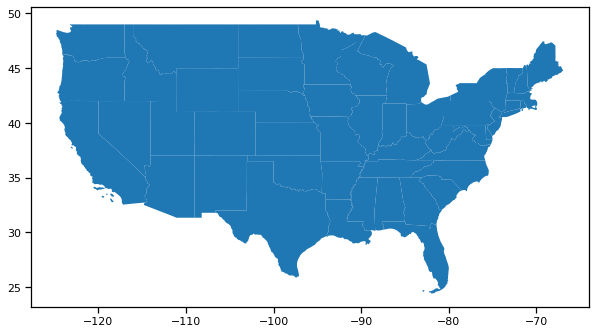

In [5]:
states = pkg.reference('us_states').geoframe().to_crs(4326)
continental_states = states[~states.stusps.isin(['HI','AK','PR','VI','MP','GU','AS'])]
continental_states.plot(figsize=(10,10))
us_boundary = continental_states.unary_union

In [6]:
t = gpd.sjoin(s, states )
state_zones = t[['zone', 'stusps']].drop_duplicates().zone

t = gpd.sjoin(s, continental_states )
cstate_zones = t[['zone', 'stusps']].drop_duplicates().zone

s['us_state'] = (s.zone.isin(state_zones)).astype(int)
s['cus_state'] = (s.zone.isin(cstate_zones)).astype(int)

<AxesSubplot:>

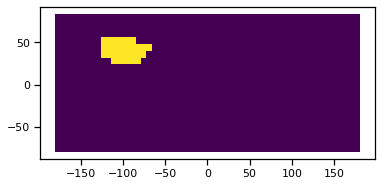

In [7]:

s.plot(column='cus_state')

In [8]:
s.head()

,geometry,band,row,west_value,cm_value,east_value,zone,epsg,us_state,cus_state
1085,"MULTIPOLYGON (((-179.99999 -72.00000, -179.000...",1,C,180W,177W,174W,01C,32701,0,0
1158,"MULTIPOLYGON (((-179.99999 -64.00000, -179.000...",1,D,180W,177W,174W,01D,32701,0,0
1032,"MULTIPOLYGON (((-179.99999 -56.00000, -179.000...",1,E,180W,177W,174W,01E,32701,0,0
789,"MULTIPOLYGON (((-179.99999 -48.00000, -179.000...",1,F,180W,177W,174W,01F,32701,0,0
999,"MULTIPOLYGON (((-179.99999 -40.00000, -179.000...",1,G,180W,177W,174W,01G,32701,0,0


In [14]:
t = s[s.cus_state == 1]

utm = gpd.GeoDataFrame(t.groupby('band').apply(lambda g: g.unary_union).to_frame('geometry'), crs=4326)

utm_bands = utm.reset_index()

utm_bands


,band,geometry
0,10,"POLYGON ((-120.00000 39.00000, -120.00000 38.0..."
1,11,"POLYGON ((-114.00000 39.00000, -114.00000 38.0..."
2,12,"POLYGON ((-108.00000 30.00000, -108.00000 29.0..."
3,13,"POLYGON ((-102.00000 30.00000, -102.00000 29.0..."
4,14,"POLYGON ((-96.00000 30.00000, -96.00000 29.000..."
5,15,"POLYGON ((-90.00000 30.00000, -90.00000 29.000..."
6,16,"POLYGON ((-84.00000 30.00000, -84.00000 29.000..."
7,17,"POLYGON ((-78.00000 31.00000, -78.00000 30.000..."
8,18,"POLYGON ((-72.00000 39.00000, -72.00000 38.000..."
9,19,"POLYGON ((-72.00000 48.00000, -71.00000 48.000..."


In [16]:
utm['geometry'] = utm.apply(lambda r: utm_transformer.buffer_utm(r.name, 10_000, r.geometry), axis=1)

utm_bands_buffered = utm.reset_index()

utm_bands_buffered

,band,geometry
0,10,"POLYGON ((-119.76924 38.99984, -119.77241 37.9..."
1,11,"POLYGON ((-113.76924 38.99984, -113.77241 37.9..."
2,12,"POLYGON ((-107.79286 29.99991, -107.79489 28.9..."
3,13,"POLYGON ((-101.79286 29.99991, -101.79489 28.9..."
4,14,"POLYGON ((-95.79286 29.99991, -95.79489 28.999..."
5,15,"POLYGON ((-89.79286 29.99991, -89.79489 28.999..."
6,16,"POLYGON ((-83.79286 29.99991, -83.79489 28.999..."
7,17,"POLYGON ((-77.79073 30.99990, -77.79286 29.999..."
8,18,"POLYGON ((-71.76924 38.99984, -71.77241 37.999..."
9,19,"POLYGON ((-72.26793 47.99963, -72.26780 48.004..."
